The goal of this project is to determine the factors that directly contribute to student success for this online program. The learning dataset was provided by The Open University in the United Kingdom.

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy import optimize
from scipy import spatial
import random

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

After importing all the libraries, I decided to preload some statistical functions that may be required throughout analysis.

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def pearson_r(x , y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size = 1):
    """perform pairs bootstrap for linear regression"""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

def draw_bs_pairs(x, y, func, size = 1):
    """Perform pairs bootstrap for a single statistic."""
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size = len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def diff_frac(data_A, data_b):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

def rmse(pred, obs):
    return np.sqrt(((pred - obs) ** 2).mean())

def mse(pred, obs):
    return ((pred - obs) ** 2).mean()

def bon_correct(alpha, n):
    return (alpha/n)

# Initial description

In [3]:
eda_df = pd.read_csv('eda_stage.csv')

In [4]:
eda_df.shape

(534781, 24)

In [5]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534781 entries, 0 to 534780
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id_student                  534781 non-null  int64 
 1   gender                      534781 non-null  object
 2   disability                  534781 non-null  object
 3   age_band                    534781 non-null  object
 4   region                      534781 non-null  object
 5   imd_band                    534781 non-null  object
 6   highest_education           534781 non-null  object
 7   id_site                     534781 non-null  int64 
 8   code_module                 534781 non-null  object
 9   code_presentation           534781 non-null  object
 10  id_assessment               534781 non-null  int64 
 11  date_registration           534781 non-null  int64 
 12  num_of_prev_attempts        534781 non-null  int64 
 13  final_result                5

In [6]:
eda_df.describe()

,id_student,id_site,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,date,sum_click
count,5.347810e+05,5.347810e+05,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000,534781.000000
mean,7.127787e+05,7.263949e+05,28436.897968,-64.392058,0.162405,81.699219,127.952180,76.409983,254.948194,9.646102,142.566363,4.769915
std,5.675385e+05,1.314079e+05,8205.247185,46.124150,0.471151,39.871460,75.137527,17.549058,13.819019,10.782572,79.696081,11.630602
min,6.516000e+03,5.267210e+05,1752.000000,-310.000000,0.000000,30.000000,-8.000000,0.000000,234.000000,0.000000,12.000000,1.000000
25%,4.974100e+05,5.510670e+05,24295.000000,-92.000000,0.000000,60.000000,54.000000,67.000000,240.000000,0.000000,67.000000,1.000000
50%,5.815520e+05,7.169890e+05,34861.000000,-52.000000,0.000000,60.000000,131.000000,80.000000,261.000000,7.000000,149.000000,2.000000
75%,6.346360e+05,8.325670e+05,34888.000000,-28.000000,0.000000,120.000000,201.000000,89.000000,268.000000,18.000000,222.000000,4.000000
max,2.698588e+06,1.046237e+06,37443.000000,101.000000,6.000000,630.000000,285.000000,100.000000,269.000000,100.000000,261.000000,655.000000


In [7]:
eda_df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,final_result,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click
0,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
1,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,forumng,19,1
2,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,homepage,19,10
3,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,2
4,2412002,Male,No,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,Distinction,90,20,86,TMA,268,10,No,subpage,19,1


I need to make the df numerically binary for more efficient EDA.

In [8]:
eda_df['disability'].replace('No', 0, inplace = True)
eda_df['disability'].replace('Yes', 1, inplace = True)

eda_df['is_banked'].replace('No', 0, inplace = True)
eda_df['is_banked'].replace('Yes', 1, inplace = True)

C:\Users\jacob\AppData\Local\Temp\ipykernel_19260\1682318704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_df['disability'].replace('No', 0, inplace = True)
C:\Users\jacob\AppData\Local\Temp\ipykernel_19260\1682318704.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [9]:
df_dup_drop = eda_df.drop_duplicates()
df_dup_drop = eda_df.reset_index(drop = True)
df_dup_drop.shape

(534781, 24)

Since I am simply looking into what determines pass or fail, all distinctions will be grouped with passes; and withdrawns will be dropped.

A new column will be added to make the pass/fail binary.

Additionally, all numerical IDs were retyped as a string to make analyses with them more categorical rather than regressional.

In [10]:
df_no_with = df_dup_drop[df_dup_drop['final_result'] != 'Withdrawn']
df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)
df = df_no_with.drop(['final_result'], axis = 1)
df[['id_student', 'id_site', 'id_assessment']] = df[['id_student', 'id_site', 'id_assessment']].astype(str)
df.shape

C:\Users\jacob\AppData\Local\Temp\ipykernel_19260\2768337301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_with['pass'] = np.where(df_no_with['final_result'] == 'Fail', 0, 1)


(534636, 24)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534636 entries, 0 to 534780
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   id_student                  534636 non-null  object
 1   gender                      534636 non-null  object
 2   disability                  534636 non-null  int64 
 3   age_band                    534636 non-null  object
 4   region                      534636 non-null  object
 5   imd_band                    534636 non-null  object
 6   highest_education           534636 non-null  object
 7   id_site                     534636 non-null  object
 8   code_module                 534636 non-null  object
 9   code_presentation           534636 non-null  object
 10  id_assessment               534636 non-null  object
 11  date_registration           534636 non-null  int64 
 12  num_of_prev_attempts        534636 non-null  int64 
 13  studied_credits             534636

In [12]:
df.describe()

,disability,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,is_banked,date,sum_click,pass
count,534636.000000,534636.000000,534636.000000,534636.000000,534636.000000,534636.000000,534636.000000,534636.00000,534636.000000,534636.000000,534636.000000,534636.000000
mean,0.077632,-64.398830,0.162430,81.697641,127.974555,76.414306,254.945359,9.64606,0.003528,142.592871,4.770487,0.796548
std,0.267592,46.126388,0.471193,39.874240,75.133073,17.546762,13.819704,10.78337,0.059289,79.688390,11.631962,0.402567
min,0.000000,-310.000000,0.000000,30.000000,-8.000000,0.000000,234.000000,0.00000,0.000000,12.000000,1.000000,0.000000
25%,0.000000,-92.000000,0.000000,60.000000,54.000000,67.000000,240.000000,0.00000,0.000000,67.000000,1.000000,1.000000
50%,0.000000,-52.000000,0.000000,60.000000,131.000000,80.000000,261.000000,7.00000,0.000000,149.000000,2.000000,1.000000
75%,0.000000,-28.000000,0.000000,120.000000,201.000000,89.000000,268.000000,18.00000,0.000000,222.000000,4.000000,1.000000
max,1.000000,101.000000,6.000000,630.000000,285.000000,100.000000,269.000000,100.00000,1.000000,261.000000,655.000000,1.000000


In [13]:
df.head()

,id_student,gender,disability,age_band,region,imd_band,highest_education,id_site,code_module,code_presentation,id_assessment,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,assessment_type,module_presentation_length,weight,is_banked,activity_type,date,sum_click,pass
0,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,forumng,19,1,1
1,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546652,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,forumng,19,1,1
2,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546614,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,homepage,19,10,1
3,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546876,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,2,1
4,2412002,Male,0,35-55,South West Region,50-60%,Lower Than A Level,546871,AAA,2013J,1752,-38,0,90,20,86,TMA,268,10,0,subpage,19,1,1


In [14]:
col_order = [x for x in df.columns]
for c in col_order:
    print(df[c].value_counts())
    print(df[c].dtypes)
    print(df[c].info())
    if pd.api.types.is_numeric_dtype(df[c]):
        print(df[c].describe())
    print()

id_student
2646317    1225
604879      648
556251      560
402449      550
308363      541
           ... 
571055        1
626091        1
572909        1
582026        1
635779        1
Name: count, Length: 16183, dtype: int64
object
<class 'pandas.core.series.Series'>
Index: 534636 entries, 0 to 534780
Series name: id_student
Non-Null Count   Dtype 
--------------   ----- 
534636 non-null  object
dtypes: object(1)
memory usage: 8.2+ MB
None

gender
Male      334964
Female    199672
Name: count, dtype: int64
object
<class 'pandas.core.series.Series'>
Index: 534636 entries, 0 to 534780
Series name: gender
Non-Null Count   Dtype 
--------------   ----- 
534636 non-null  object
dtypes: object(1)
memory usage: 8.2+ MB
None

disability
0    493131
1     41505
Name: count, dtype: int64
int64
<class 'pandas.core.series.Series'>
Index: 534636 entries, 0 to 534780
Series name: disability
Non-Null Count   Dtype
--------------   -----
534636 non-null  int64
dtypes: int64(1)
memory usage: 8.2 MB


# Random Forest Modeling

The random forest is being used to get an initial impression of the features that I may be able to ignore or spend more time on.

I removed all identifying information in my preprocessing for random forest modeling; assuming that each student identity was equally capable, and all courses or assessment identities were equally impactful on the end result.

Descriptors of these identities (gender, score, module_presentation_length, etc.) were still analyzed.

In [15]:
df_no_id = df.drop(['id_student', 'id_site', 'id_assessment', 'code_module', 'code_presentation', ], axis = 1)
cat_col = df_no_id.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output = False)
one_hot_encoded = encoder.fit_transform(df_no_id[cat_col])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_col))
one_hot_df.head()

,gender_Female,gender_Male,age_band_0-35,age_band_35-55,age_band_55<=,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
df_encoded = pd.concat([df_no_id, one_hot_df], axis = 1)
df_encoded = df_encoded.drop(cat_col, axis = 1)
df_encoded.shape

(534781, 67)

One hot encoding was necessary to process all of my categorical data.

In [17]:
df_encoded[df_encoded.isna().any(axis = 1)]

,disability,date_registration,num_of_prev_attempts,studied_credits,date_submitted,score,module_presentation_length,weight,is_banked,date,sum_click,pass,gender_Female,gender_Male,age_band_0-35,age_band_35-55,age_band_55<=,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,imd_band_0-10%,imd_band_10-20%,imd_band_20-30%,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,highest_education_A Level or Equivalent,highest_education_HE Qualification,highest_education_Lower Than A Level,highest_education_No Formal quals,highest_education_Post Graduate Qualification,assessment_type_CMA,assessment_type_Exam,assessment_type_TMA,activity_type_dataplus,activity_type_dualpane,activity_type_externalquiz,activity_type_folder,activity_type_forumng,activity_type_glossary,activity_type_homepage,activity_type_htmlactivity,activity_type_oucollaborate,activity_type_oucontent,activity_type_ouelluminate,activity_type_ouwiki,activity_type_page,activity_type_questionnaire,activity_type_quiz,activity_type_resource,activity_type_sharedsubpage,activity_type_subpage,activity_type_url
534636,0.0,-113.0,1.0,30.0,230.0,40.0,269.0,0.0,0.0,229.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534637,0.0,-113.0,1.0,30.0,230.0,40.0,269.0,0.0,0.0,229.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534638,0.0,-113.0,1.0,30.0,230.0,0.0,269.0,0.0,0.0,229.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534639,0.0,-113.0,1.0,30.0,93.0,80.0,269.0,0.0,0.0,229.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534640,0.0,-113.0,1.0,30.0,231.0,60.0,269.0,0.0,0.0,229.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
510860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [18]:
df_rf = df_encoded.dropna()
df_rf.isna().sum()

disability                     0
date_registration              0
num_of_prev_attempts           0
studied_credits                0
date_submitted                 0
                              ..
activity_type_quiz             0
activity_type_resource         0
activity_type_sharedsubpage    0
activity_type_subpage          0
activity_type_url              0
Length: 67, dtype: int64

In [19]:
df_rf.shape

(534491, 67)

To combat overfitting and increase computing efficiency, the training and test sets were created from a subsample of the data.

In [20]:
rf_df = df_rf.sample(frac = 0.5, replace = False, axis = 0, random_state = 6022)
rf_df.shape

(267246, 67)

The final result of whether a student passed or failed is the leaf of each tree as the end goal.

In [21]:
x = rf_df.drop(['pass'], axis = 1)
y = rf_df['pass']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [22]:
rf = RandomForestClassifier(random_state = 6022)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [23]:
print(accuracy)

0.9575076333592768


In [24]:
param_dist = {'n_estimators': stats.randint(50, 500), 'max_depth': [int(x) for x in np.linspace(start = 1, stop = np.sqrt(len(x.columns)).astype(int), num = 15)], 'max_features': stats.randint(1, 10)}

rf = RandomForestClassifier(random_state = 6022)

In [25]:
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 5, cv = 10, random_state = 6022)

In [26]:
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=6022),
                   n_iter=5,
                   param_distributions={'max_depth': [1, 1, 2, 2, 3, 3, 4, 4, 5,
                                                      5, 6, 6, 7, 7, 8],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF73CC2E70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF73E9DE20>},
                   random_state=6022)

In [27]:
best_rf = rand_search.best_estimator_

print(rand_search.best_params_)

{'max_depth': 7, 'max_features': 9, 'n_estimators': 116}


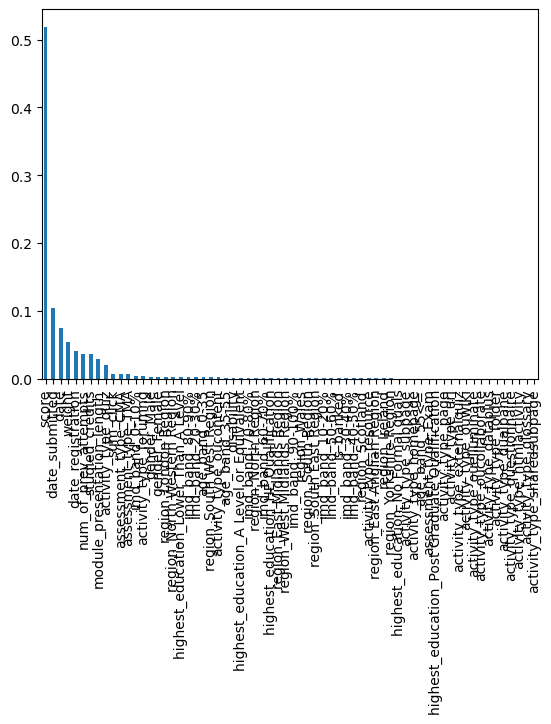

In [28]:
feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_importances.plot.bar();

In [29]:
print(feature_importances.to_string())

score                                            0.518721
date_submitted                                   0.104526
date                                             0.075443
weight                                           0.054020
date_registration                                0.040580
num_of_prev_attempts                             0.036983
studied_credits                                  0.036400
module_presentation_length                       0.028715
activity_type_quiz                               0.021090
sum_click                                        0.007423
assessment_type_CMA                              0.006723
assessment_type_TMA                              0.006653
imd_band_0-10%                                   0.004118
activity_type_forumng                            0.003588
gender_Male                                      0.003169
gender_Female                                    0.002729
region_London Region                             0.002563
region_North W

In [30]:
feature_importances.head(10)

score                         0.518721
date_submitted                0.104526
date                          0.075443
weight                        0.054020
date_registration             0.040580
num_of_prev_attempts          0.036983
studied_credits               0.036400
module_presentation_length    0.028715
activity_type_quiz            0.021090
sum_click                     0.007423
dtype: float64

In [31]:
feature_importances.tail(10)

activity_type_ouwiki           0.000094
activity_type_ouelluminate     0.000073
activity_type_oucollaborate    0.000057
activity_type_dataplus         0.000048
activity_type_folder           0.000043
activity_type_dualpane         0.000039
activity_type_questionnaire    0.000029
activity_type_htmlactivity     0.000014
activity_type_glossary         0.000005
activity_type_sharedsubpage    0.000000
dtype: float64

Score was by far the most relevant with a 51% mean decrease in impurity. To expedite EDA, all of the top features were listed.

Activity and other one hot encoded features were weighed lighter than other features. I hesitate to accept that activity was unimportant except for quizzes since the model could still be boosted for determining relevance.

# EDA

In [32]:
rel_top = ['score', 'date_submitted', 'date', 'studied_credits',
           'weight', 'date_registration', 'num_of_prev_attempts',
           'module_presentation_length', 'sum_click']

For the purposes of analysis weight will be removed. Weight describes how impactful each assessment is on the final grade. A heavier weighted assignment would fluctuate the final score of a student greater than a lighter weighing assessment.

## Activity_type

In [33]:
table = pd.crosstab(df['activity_type'], df['pass']).values
x_chi = stats.chi2_contingency(table)
print(f'Chi squared stats: {x_chi.statistic}')
print(f'Chi squared p-value: {x_chi.pvalue}')
print(f'Bonferoni corrected alpha: {bon_correct(0.05, x_chi.dof)}')
if x_chi.pvalue <= bon_correct(0.05, x_chi.dof):
    print(f'Since {x_chi.pvalue} is less than or equal to {bon_correct(0.05, x_chi.dof)}, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of the type of activity.')
else:
    print(f'Since {x_chi.pvalue} is greater than {bon_correct(0.05, x_chi.dof)}, we accept the null hypothesis that a passing final result may be independent of the type of activity.')

Chi squared stats: 9257.122884025364
Chi squared p-value: 0.0
Bonferoni corrected alpha: 0.002777777777777778
Since 0.0 is less than or equal to 0.002777777777777778, we reject the null hypothesis in favor of the alternative; that a passing final result may not be independent of the type of activity.


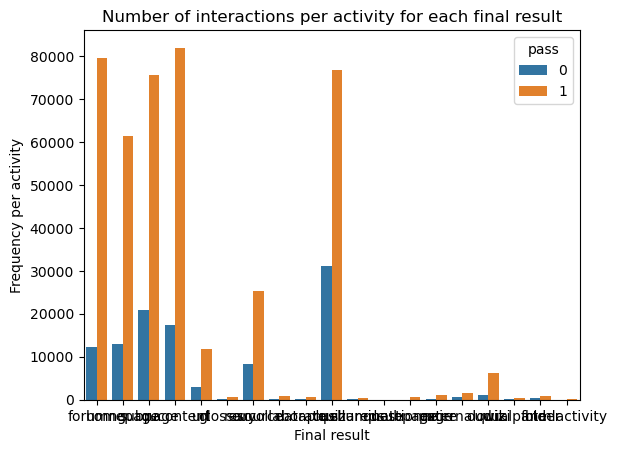

In [34]:
_ = sns.countplot(x = 'activity_type', data = df, hue = 'pass')
_ = plt.xlabel('Final result')
_ = plt.ylabel('Frequency per activity')
_ = plt.title('Number of interactions per activity for each final result')
plt.show()

In [35]:
print(df['activity_type'].value_counts(normalize = True))

activity_type
quiz             0.201747
oucontent        0.185689
subpage          0.180495
forumng          0.171868
homepage         0.139140
resource         0.062590
url              0.027978
ouwiki           0.013779
externalquiz     0.004276
page             0.002484
folder           0.002158
oucollaborate    0.002082
glossary         0.001257
ouelluminate     0.001216
questionnaire    0.001206
dataplus         0.001130
dualpane         0.000786
htmlactivity     0.000116
sharedsubpage    0.000004
Name: proportion, dtype: float64


In [36]:
print(df[df['pass'] == 1]['activity_type'].value_counts(normalize = True))

activity_type
oucontent        0.192360
forumng          0.186743
quiz             0.180342
subpage          0.177684
homepage         0.144183
resource         0.059268
url              0.027941
ouwiki           0.014831
externalquiz     0.003823
page             0.002630
oucollaborate    0.002184
folder           0.001994
questionnaire    0.001423
glossary         0.001294
dataplus         0.001256
ouelluminate     0.001106
dualpane         0.000805
htmlactivity     0.000131
sharedsubpage    0.000002
Name: proportion, dtype: float64


In [37]:
print(df[df['pass'] == 0]['activity_type'].value_counts(normalize = True))

activity_type
quiz             0.285549
subpage          0.191500
oucontent        0.159571
homepage         0.119395
forumng          0.113631
resource         0.075598
url              0.028123
ouwiki           0.009662
externalquiz     0.006049
folder           0.002804
page             0.001912
oucollaborate    0.001682
ouelluminate     0.001646
glossary         0.001112
dualpane         0.000708
dataplus         0.000634
questionnaire    0.000359
htmlactivity     0.000055
sharedsubpage    0.000009
Name: proportion, dtype: float64


Interacting with the quizzes more increases the chance that the student also have failed by about 10%.

## Numeric Important Features

score


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


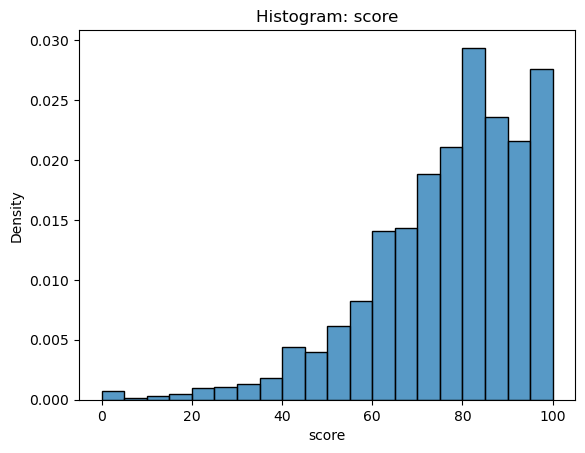

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

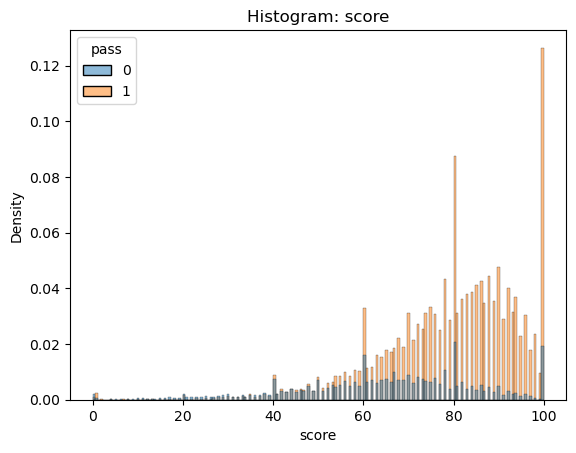

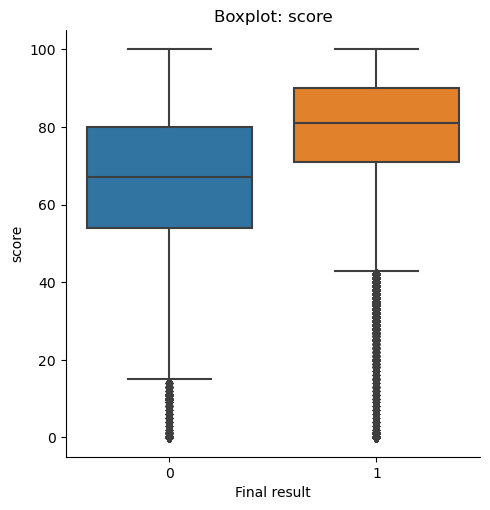

Overall
Mean: 76.4143061821501
Std: 17.54676189576177
Median: 80.0
Quartiles: 0.25    67.0
0.75    89.0
Name: score, dtype: float64

Passed
Mean: 79.25524875370718
Std: 15.628606713672948
Median: 81.0
Minimum: 0
Quartiles: 0.25    71.0
0.75    90.0
Name: score, dtype: float64
Max: 100

Failed
Mean: 65.29157971187703
Std: 20.042970482854884
Median: 67.0
Minimum: 0
Quartiles: 0.25    54.0
0.75    80.0
Name: score, dtype: float64
Max: 100

date_submitted


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


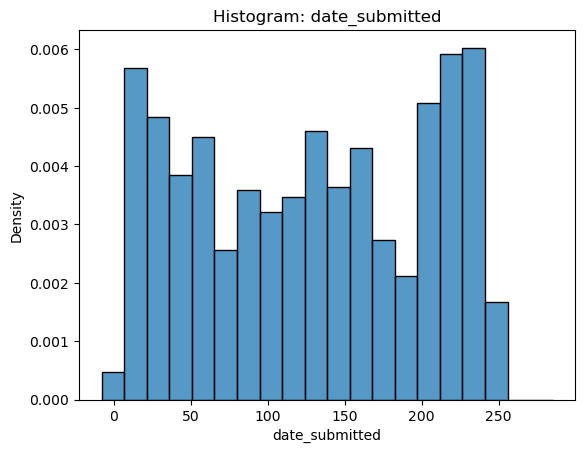

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

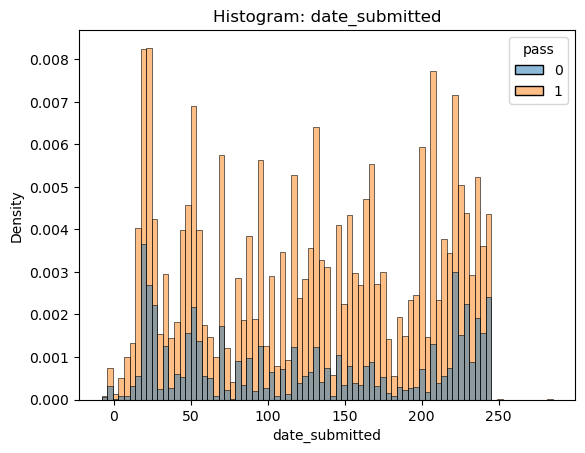

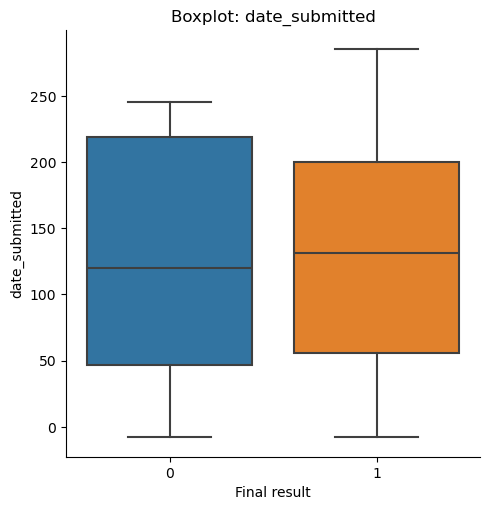

Overall
Mean: 127.97455465026673
Std: 75.13307313442733
Median: 131.0
Quartiles: 0.25     54.0
0.75    201.0
Name: date_submitted, dtype: float64

Passed
Mean: 128.60407454979654
Std: 73.39006362569897
Median: 131.0
Minimum: -8
Quartiles: 0.25     56.0
0.75    200.0
Name: date_submitted, dtype: float64
Max: 285

Failed
Mean: 125.50988756400945
Std: 81.55339020394293
Median: 120.0
Minimum: -8
Quartiles: 0.25     47.0
0.75    219.0
Name: date_submitted, dtype: float64
Max: 245

date


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


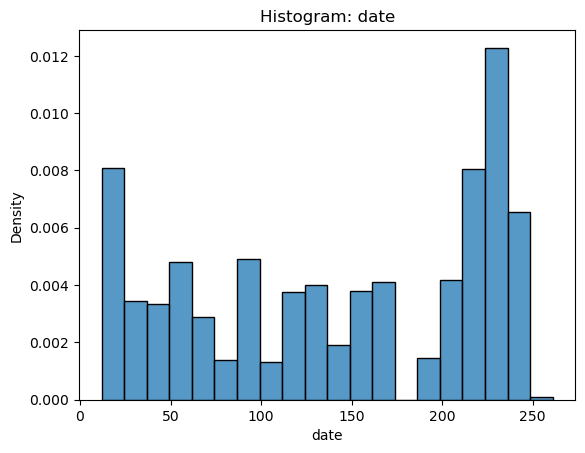

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

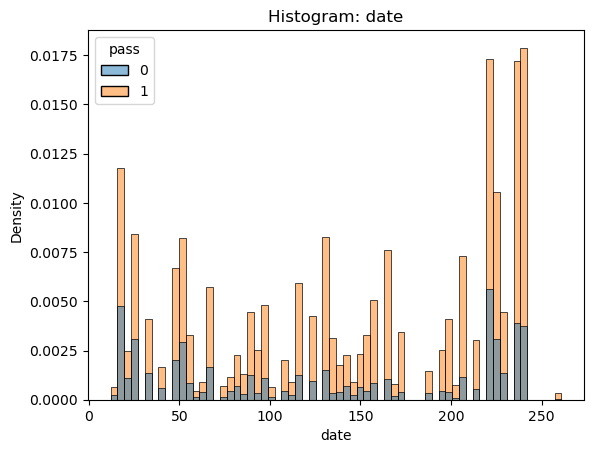

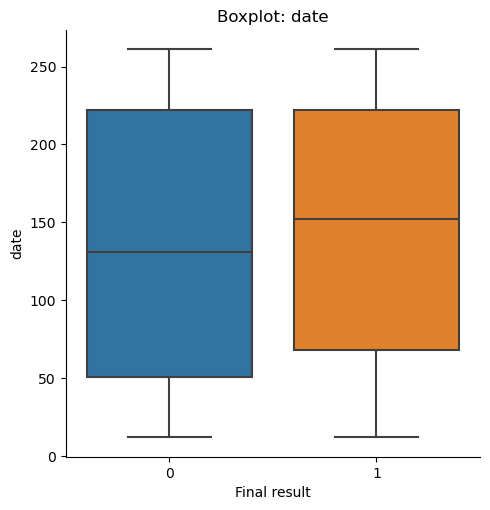

Overall
Mean: 142.59287066340463
Std: 79.68838960421577
Median: 149.0
Quartiles: 0.25     67.0
0.75    222.0
Name: date, dtype: float64

Passed
Mean: 145.25392203595993
Std: 78.30143670490055
Median: 152.0
Minimum: 12
Quartiles: 0.25     68.0
0.75    222.0
Name: date, dtype: float64
Max: 261

Failed
Mean: 132.17444586432293
Std: 84.09483197555033
Median: 131.0
Minimum: 12
Quartiles: 0.25     51.0
0.75    222.0
Name: date, dtype: float64
Max: 261

studied_credits


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


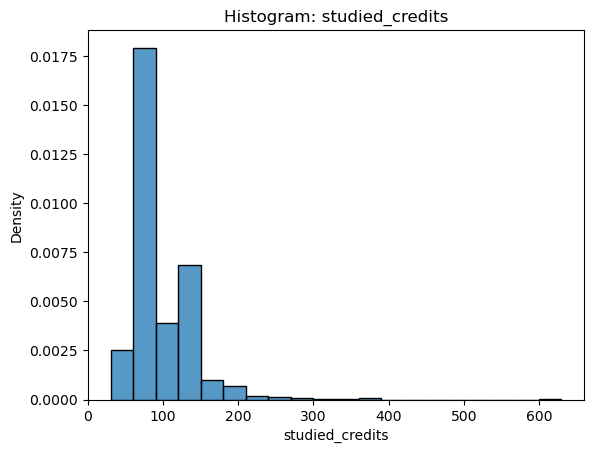

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

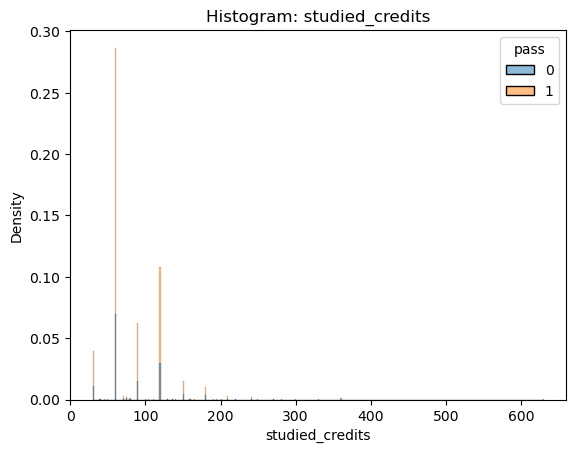

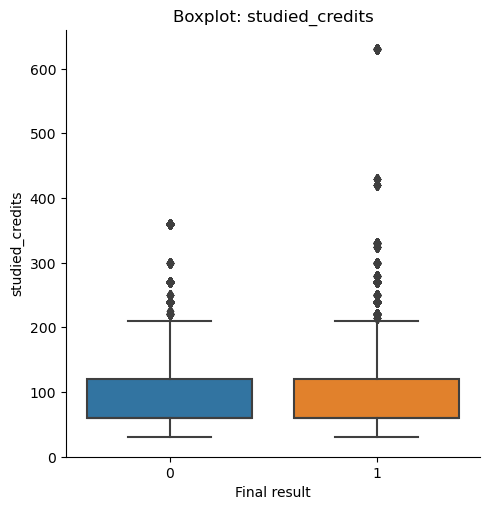

Overall
Mean: 81.69764101182861
Std: 39.87423970240563
Median: 60.0
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64

Passed
Mean: 80.84029370947934
Std: 37.97668170161887
Median: 60.0
Minimum: 30
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64
Max: 630

Failed
Mean: 85.05428736910814
Std: 46.413371241300844
Median: 60.0
Minimum: 30
Quartiles: 0.25     60.0
0.75    120.0
Name: studied_credits, dtype: float64
Max: 360

weight


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


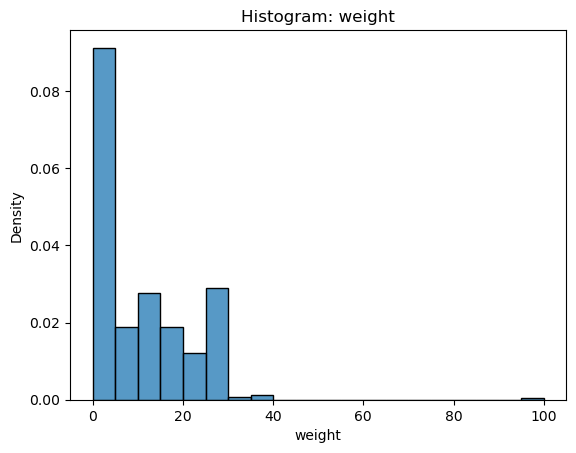

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

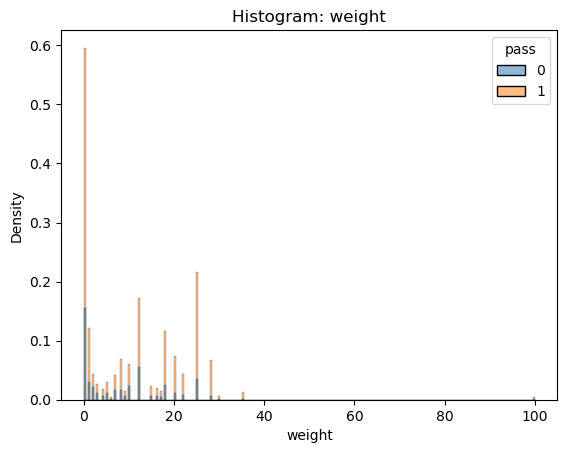

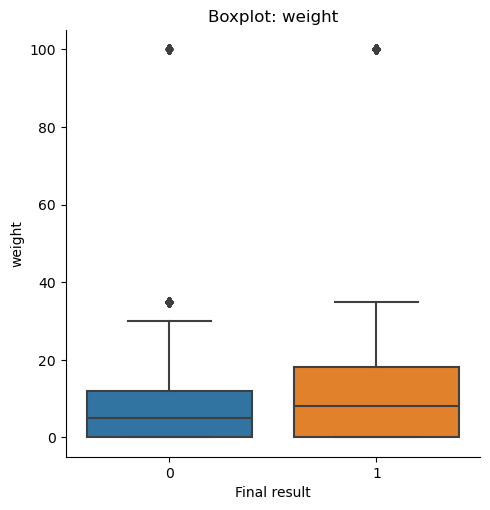

Overall
Mean: 9.646060123149208
Std: 10.783370192848416
Median: 7.0
Quartiles: 0.25     0.0
0.75    18.0
Name: weight, dtype: float64

Passed
Mean: 10.059077684607491
Std: 11.113125712372927
Median: 8.0
Minimum: 0
Quartiles: 0.25     0.0
0.75    18.0
Name: weight, dtype: float64
Max: 100

Failed
Mean: 8.029032940159782
Std: 9.204887384989995
Median: 5.0
Minimum: 0
Quartiles: 0.25     0.0
0.75    12.0
Name: weight, dtype: float64
Max: 100

date_registration


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


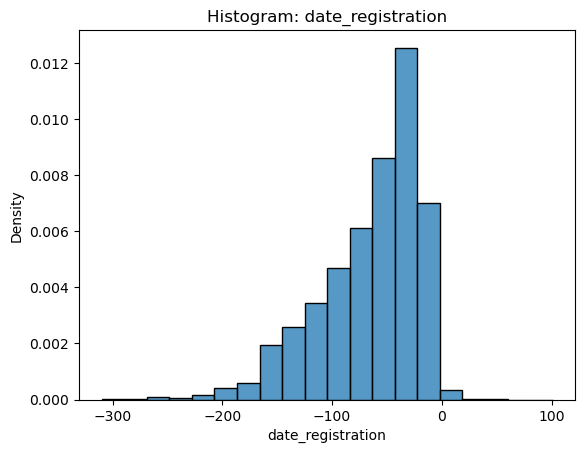

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

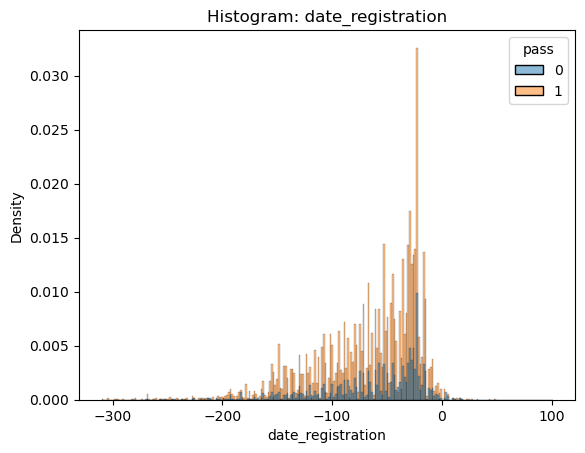

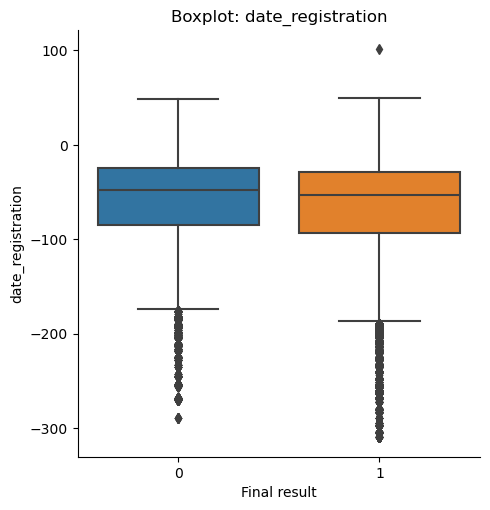

Overall
Mean: -64.39883023215795
Std: 46.126387946446265
Median: -52.0
Quartiles: 0.25   -92.0
0.75   -28.0
Name: date_registration, dtype: float64

Passed
Mean: -65.40843181962275
Std: 46.50123748635769
Median: -53.0
Minimum: -310
Quartiles: 0.25   -93.0
0.75   -29.0
Name: date_registration, dtype: float64
Max: 101

Failed
Mean: -60.44608496593824
Std: 44.40841720979753
Median: -48.0
Minimum: -289
Quartiles: 0.25   -85.0
0.75   -25.0
Name: date_registration, dtype: float64
Max: 48

num_of_prev_attempts


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


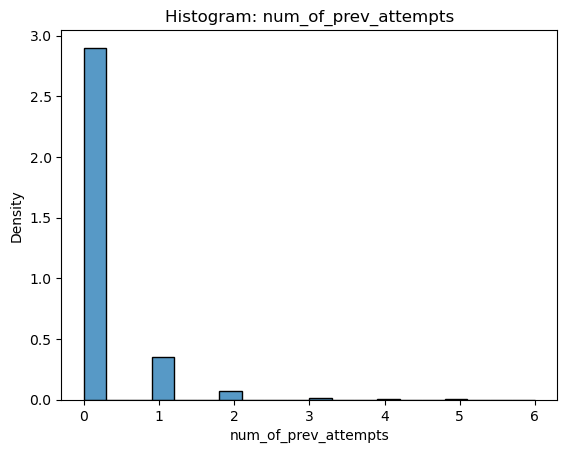

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

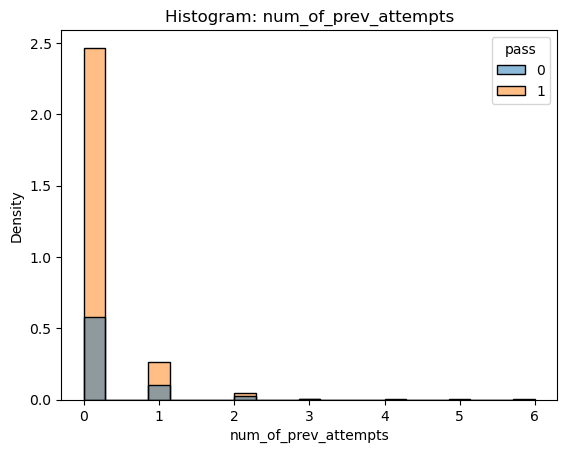

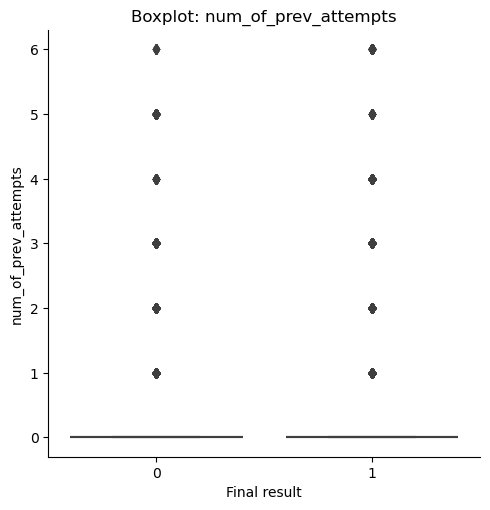

Overall
Mean: 0.16243013938455322
Std: 0.4711934395626151
Median: 0.0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64

Passed
Mean: 0.14277126681585392
Std: 0.441442515020409
Median: 0.0
Minimum: 0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64
Max: 6

Failed
Mean: 0.23939764463607696
Std: 0.5664734683947192
Median: 0.0
Minimum: 0
Quartiles: 0.25    0.0
0.75    0.0
Name: num_of_prev_attempts, dtype: float64
Max: 6

module_presentation_length


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


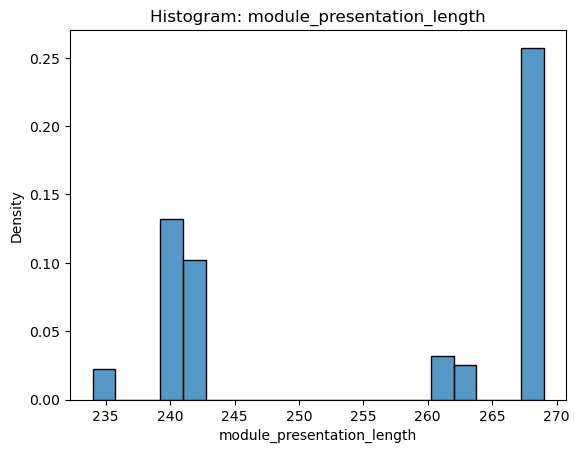

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

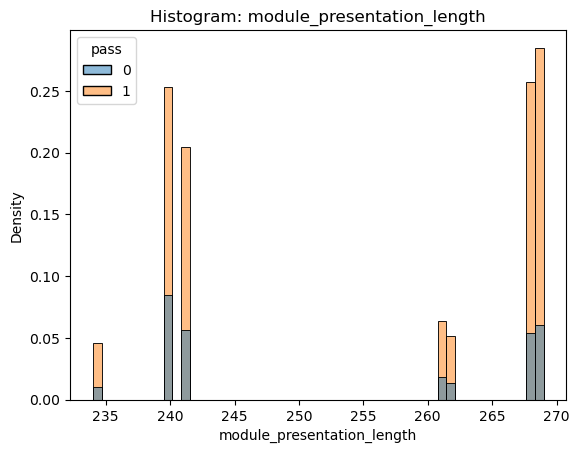

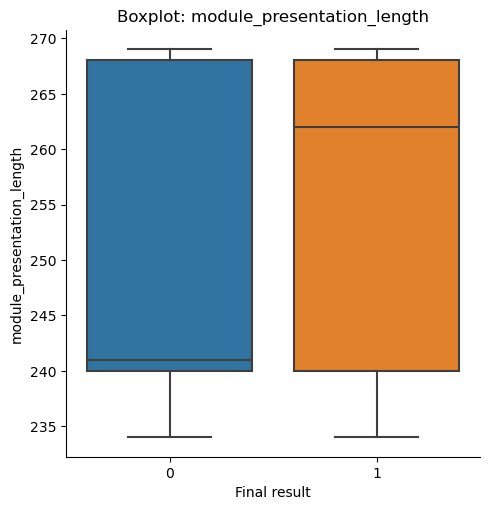

Overall
Mean: 254.94535908543384
Std: 13.81970434094963
Median: 261.0
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64

Passed
Mean: 255.3820806221719
Std: 13.80863033319024
Median: 262.0
Minimum: 234
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64
Max: 269

Failed
Mean: 253.2355271988453
Std: 13.73002473143956
Median: 241.0
Minimum: 234
Quartiles: 0.25    240.0
0.75    268.0
Name: module_presentation_length, dtype: float64
Max: 269

sum_click


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


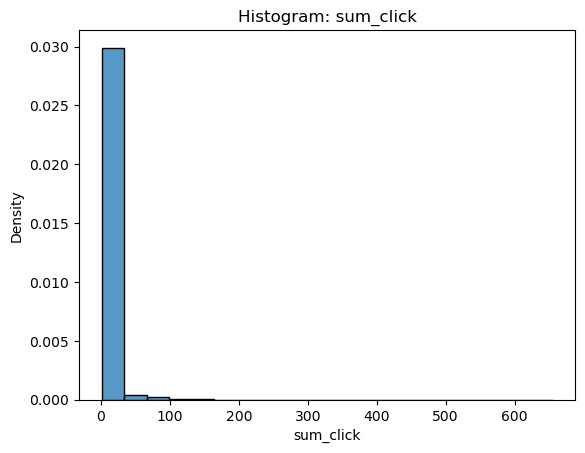

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_

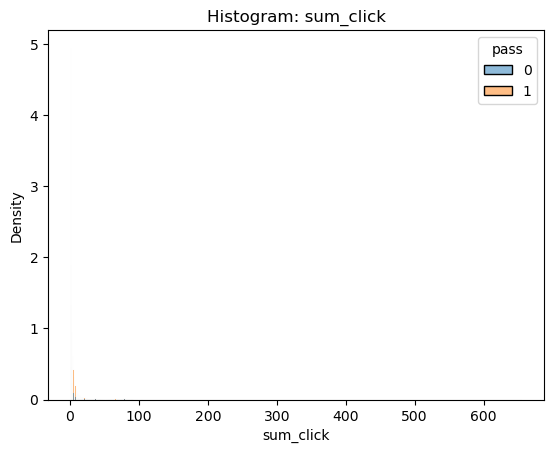

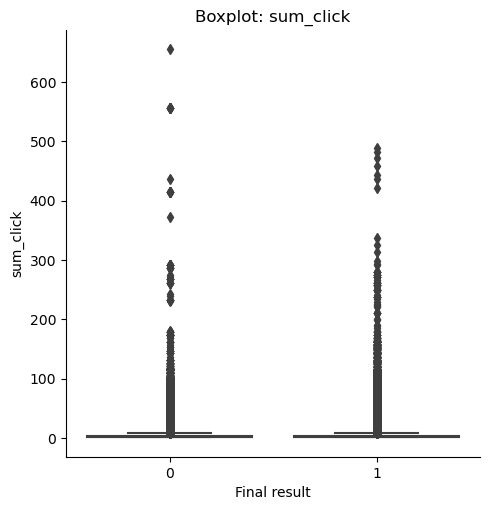

Overall
Mean: 4.770486835903307
Std: 11.631961670445127
Median: 2.0
Quartiles: 0.25    1.0
0.75    4.0
Name: sum_click, dtype: float64

Passed
Mean: 4.601425810648025
Std: 10.555342651826633
Median: 2.0
Minimum: 1
Quartiles: 0.25    1.0
0.75    4.0
Name: sum_click, dtype: float64
Max: 488

Failed
Mean: 5.432386713614592
Std: 15.108829997906057
Median: 2.0
Minimum: 1
Quartiles: 0.25    1.0
0.75    4.0
Name: sum_click, dtype: float64
Max: 655



In [38]:
for i in rel_top:
    print(i)
    _ = sns.histplot(x = i, data = df, stat = 'density', bins = 20)
    _ = plt.xlabel(f'{i}')
    _ = plt.ylabel('Density')
    _ = plt.title(f'Histogram: {i}')
    plt.show()

    _ = sns.histplot(x = i, data = df, hue = 'pass', stat = 'density')
    _ = plt.xlabel(f'{i}')
    _ = plt.ylabel('Density')
    _ = plt.title(f'Histogram: {i}')
    plt.show()
    
    _ = sns.catplot(x = 'pass', y = i, data = df, kind = 'box')
    _ = plt.xlabel('Final result')
    _ = plt.ylabel(f'{i}')
    _ = plt.title(f'Boxplot: {i}')
    plt.show()
    
    print('Overall')
    print(f'Mean: {df[i].mean()}')
    print(f'Std: {df[i].std()}')
    print(f'Median: {df[i].median()}')
    print(f'Quartiles: {df[i].quantile([0.25, 0.75])}')
    print()
    print('Passed')
    print(f'Mean: {df[df['pass'] == 1][i].mean()}')
    print(f'Std: {df[df['pass'] == 1][i].std()}')
    print(f'Median: {df[df['pass'] == 1][i].median()}')
    print(f'Minimum: {df[df['pass'] == 1][i].min()}')
    print(f'Quartiles: {df[df['pass'] == 1][i].quantile([0.25, 0.75])}')
    print(f'Max: {df[df['pass'] == 1][i].max()}')
    print()
    
    print('Failed')
    print(f'Mean: {df[df['pass'] == 0][i].mean()}')
    print(f'Std: {df[df['pass'] == 0][i].std()}')
    print(f'Median: {df[df['pass'] == 0][i].median()}')
    print(f'Minimum: {df[df['pass'] == 0][i].min()}')
    print(f'Quartiles: {df[df['pass'] == 0][i].quantile([0.25, 0.75])}')
    print(f'Max: {df[df['pass'] == 0][i].max()}')
    print()

## Interactions per student for each module

In [39]:
date_df = df.groupby(['pass', 'code_module', 'id_student'])['date'].agg(['count'])
date_df = date_df.reset_index()

In [40]:
date_df['count'].describe()

count    17170.000000
mean        31.137798
std         45.018216
min          1.000000
25%          8.000000
50%         18.000000
75%         37.000000
max       1225.000000
Name: count, dtype: float64

In [41]:
print('fail')
print(date_df[date_df['pass'] == 0]['count'].describe())
print()

print('pass')
print(date_df[date_df['pass'] == 1]['count'].describe())

fail
count    4136.000000
mean       26.299081
std        45.872577
min         1.000000
25%         6.000000
50%        14.000000
75%        28.000000
max       550.000000
Name: count, dtype: float64

pass
count    13034.000000
mean        32.673239
std         44.635973
min          1.000000
25%          9.000000
50%         20.000000
75%         39.000000
max       1225.000000
Name: count, dtype: float64


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

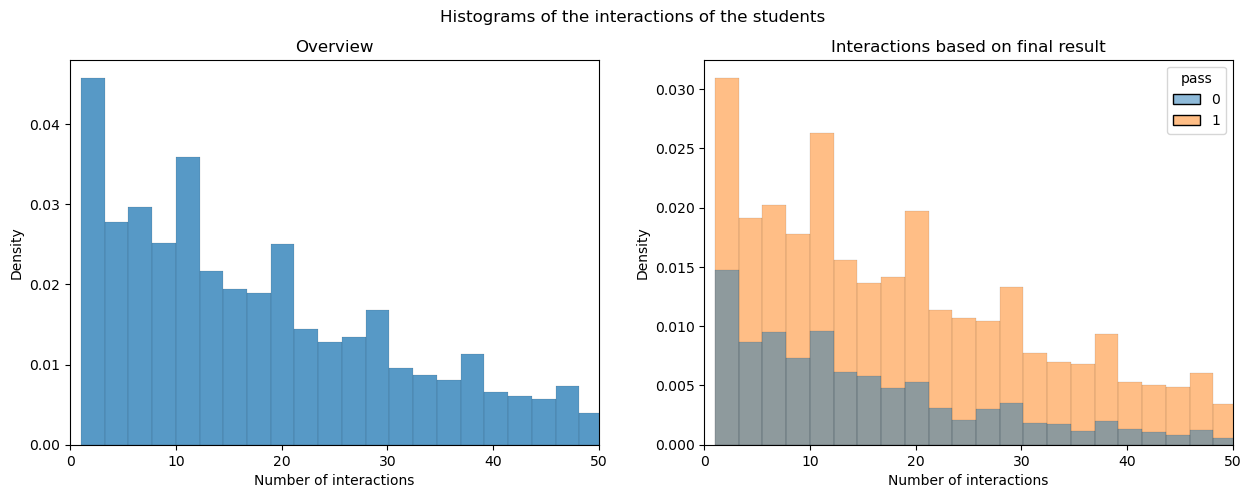

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle('Histograms of the interactions of the students')

sns.histplot(ax = ax[0], data = date_df, x = 'count', stat = 'density')
ax[0].set_xlabel('Number of interactions')
ax[0].set_title('Overview')
ax[0].set_xlim([0, 50])
ax[0].set_ylabel('Density')

sns.histplot(ax = ax[1], data = date_df, x = 'count', hue = 'pass', stat = 'density')
ax[1].set_xlabel('Number of interactions')
ax[1].set_title('Interactions based on final result')
ax[1].set_xlim([0, 50])

plt.show()

In [43]:
inter_mean = np.mean(date_df['count'])
inter_theor = np.random.exponential(inter_mean, 10000)
x_theor, y_theor = ecdf(inter_theor)

In [44]:
np_date = date_df['count'].values
x, y = ecdf(np_date)

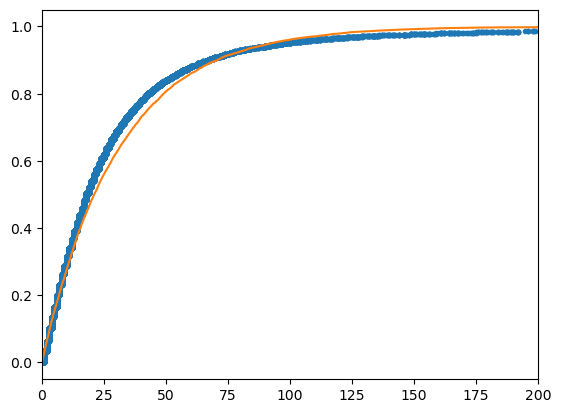

In [45]:
_ = plt.plot(x, y, linestyle = 'none', marker = '.')
_ = plt.plot(x_theor, y_theor)
_ = plt.xlim([0,200])
plt.show()

## Time distribution of how long students took ot complete each assessment

C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

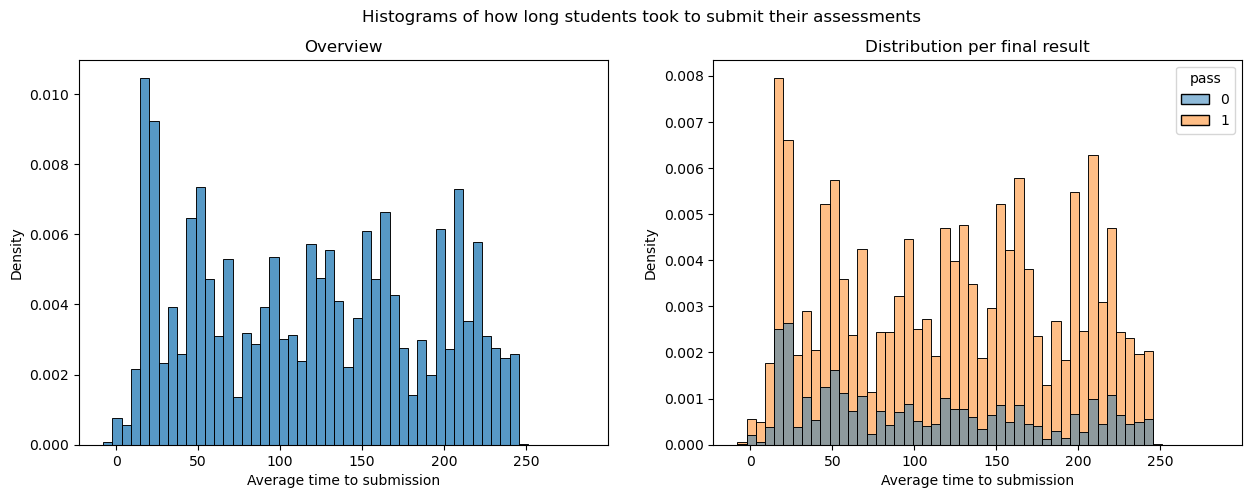

In [46]:
submitted_df = df.groupby(['pass', 'id_assessment', 'id_student'])['date_submitted'].agg(['mean', 'std'])
submitted_df = submitted_df.reset_index()

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle('Histograms of how long students took to submit their assessments')

sns.histplot(ax = ax[0], data = submitted_df, x = 'mean', stat = 'density')
ax[0].set_xlabel('Average time to submission')
ax[0].set_title('Overview')
ax[0].set_ylabel('Density')

sns.histplot(ax = ax[1], data = submitted_df, x = 'mean', stat = 'density', hue = 'pass')
ax[1].set_xlabel('Average time to submission')
ax[1].set_title('Distribution per final result')

plt.show()

In [47]:
print('fail')
print(submitted_df[submitted_df['pass'] == 0]['mean'].describe())
print()

print('pass')
print(submitted_df[submitted_df['pass'] == 1]['mean'].describe())

fail
count    13534.000000
mean       105.116078
std         71.468747
min         -8.000000
25%         44.000000
50%         94.000000
75%        164.000000
max        245.000000
Name: mean, dtype: float64

pass
count    63146.000000
mean       121.393976
std         69.021619
min         -8.000000
25%         54.000000
50%        124.000000
75%        178.000000
max        285.000000
Name: mean, dtype: float64


In [48]:
submit_mean = np.mean(submitted_df['mean'])
submit_theor = np.random.normal(submit_mean, size = 10000)
x_theor, y_theor = ecdf(submit_theor)

In [49]:
np_submit = submitted_df['mean'].values
x, y = ecdf(np_submit)

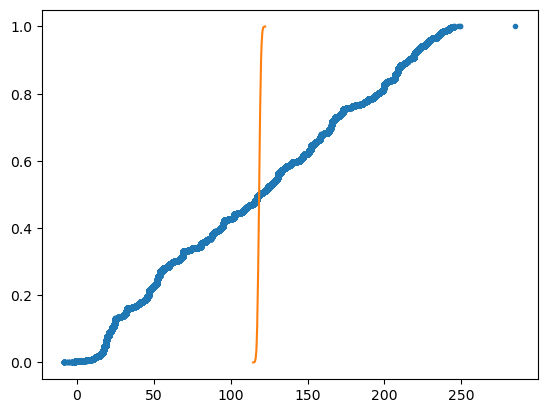

In [50]:
_ = plt.plot(x, y, linestyle = 'none', marker = '.')
_ = plt.plot(x_theor, y_theor)
plt.show()

In [51]:
bs_submit = submitted_df.sample(n = 10000, replace = True, random_state = 6022)
bs_submit.shape

(10000, 5)

In [52]:
bs_mean = np.mean(bs_submit['mean'])
bs_theor = np.random.normal(bs_mean, size = 10000)
x_theor, y_theor = ecdf(bs_theor)

In [53]:
np_bs = bs_submit['mean'].values
x, y = ecdf(np_bs)

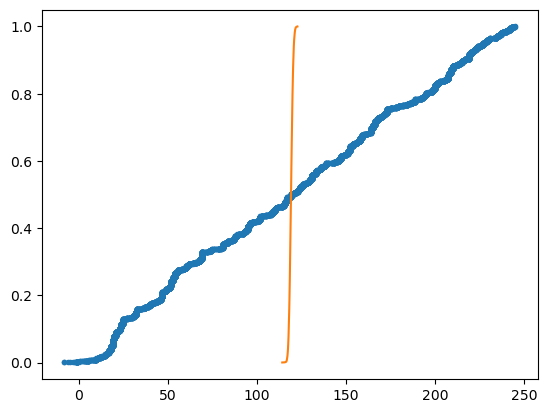

In [54]:
_ = plt.plot(x, y, linestyle = 'none', marker = '.')
_ = plt.plot(x_theor, y_theor)
plt.show()

## Average score per student for each assessment

In [55]:
score_df = df.groupby(['pass', 'id_assessment', 'id_student'])['score'].agg(['mean', 'std'])
score_df = score_df.reset_index()
score_df.head()

,pass,id_assessment,id_student,mean,std
0,0,14984,1098728,75.0,0.0
1,0,14984,120994,70.0,0.0
2,0,14984,147876,84.0,0.0
3,0,14984,161678,40.0,NaN
4,0,14984,173316,60.0,0.0


In [56]:
print('fail')
print(score_df[score_df['pass'] == 0]['mean'].describe())
print()

print('pass')
print(score_df[score_df['pass'] == 1]['mean'].describe())

fail
count    13534.000000
mean        64.316019
std         20.778351
min          0.000000
25%         52.000000
50%         66.000000
75%         80.000000
max        100.000000
Name: mean, dtype: float64

pass
count    63146.000000
mean        79.548253
std         15.778565
min          0.000000
25%         71.000000
50%         81.000000
75%         91.000000
max        100.000000
Name: mean, dtype: float64


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

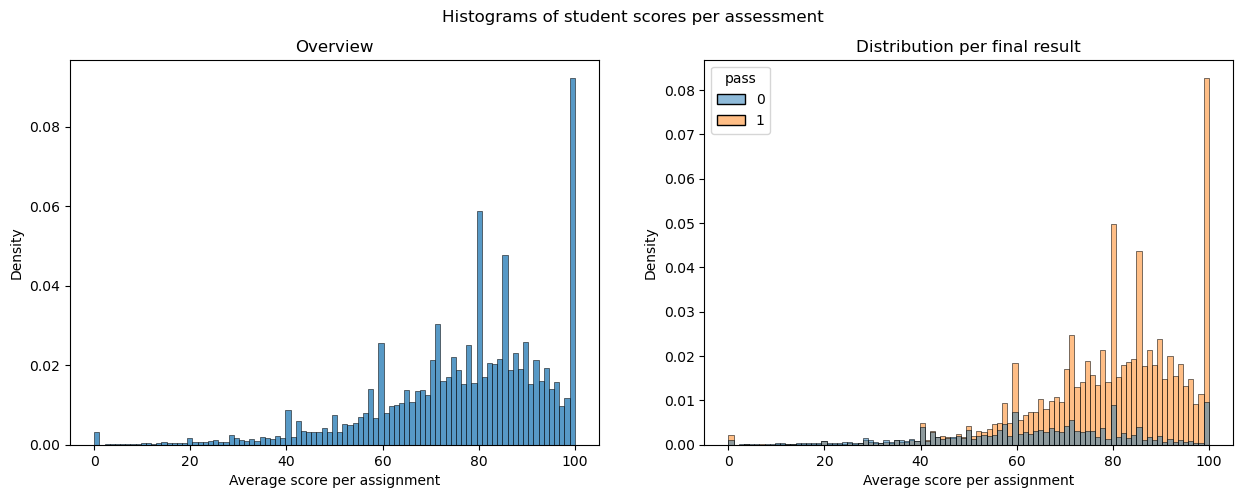

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle('Histograms of student scores per assessment')

sns.histplot(ax = ax[0], data = score_df, x = 'mean', stat = 'density')
ax[0].set_title('Overview')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Average score per assignment')

sns.histplot(ax = ax[1], data = score_df, x = 'mean', stat = 'density', hue = 'pass')
ax[1].set_xlabel('Average score per assignment')
ax[1].set_ylabel('Density')
ax[1].set_title('Distribution per final result')

plt.show()

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

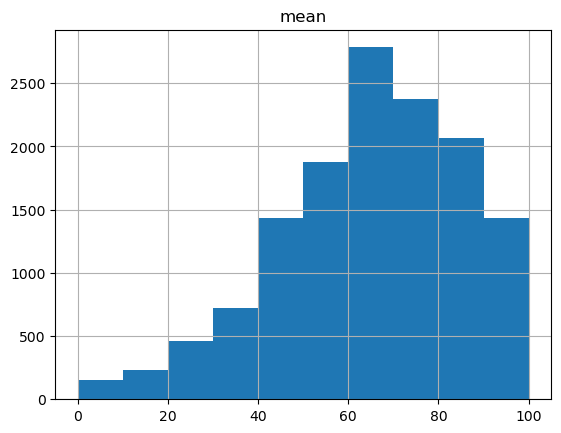

In [58]:
score_fail_df = score_df[score_df['pass'] == 0]
score_fail_df.hist(column = 'mean')

array([[<Axes: title={'center': 'mean'}>]], dtype=object)

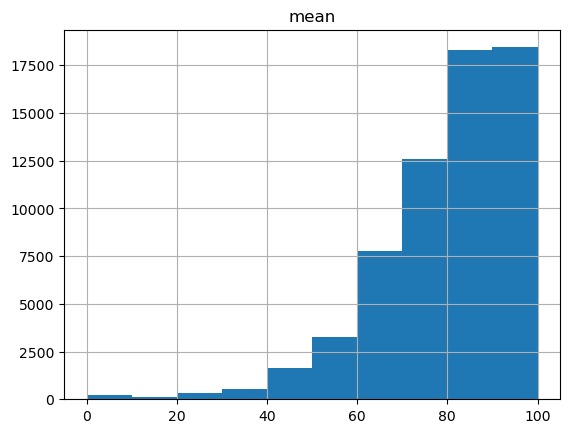

In [59]:
score_pass_df = score_df[score_df['pass'] == 1]
score_pass_df.hist(column = 'mean')

## Distribution of study credits per student

In [60]:
studied_df = df.groupby(['pass', 'id_student'])['studied_credits'].agg(['mean', 'std'])
studied_df = studied_df.reset_index()
studied_df.head()

,pass,id_student,mean,std
0,0,100561,60.0,0.0
1,0,101306,120.0,0.0
2,0,101634,90.0,NaN
3,0,1017773,60.0,NaN
4,0,1018685,60.0,0.0


In [61]:
print('fail')
print(studied_df[studied_df['pass'] == 0]['mean'].describe())
print()

print('pass')
print(studied_df[studied_df['pass'] == 1]['mean'].describe())

fail
count    4063.000000
mean       78.972612
std        38.760442
min        30.000000
25%        60.000000
50%        60.000000
75%       120.000000
max       360.000000
Name: mean, dtype: float64

pass
count    12343.000000
mean        75.069877
std         36.006243
min         30.000000
25%         60.000000
50%         60.000000
75%         90.000000
max        630.000000
Name: mean, dtype: float64


C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\jacob\anaconda3\envs\notebook\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping w

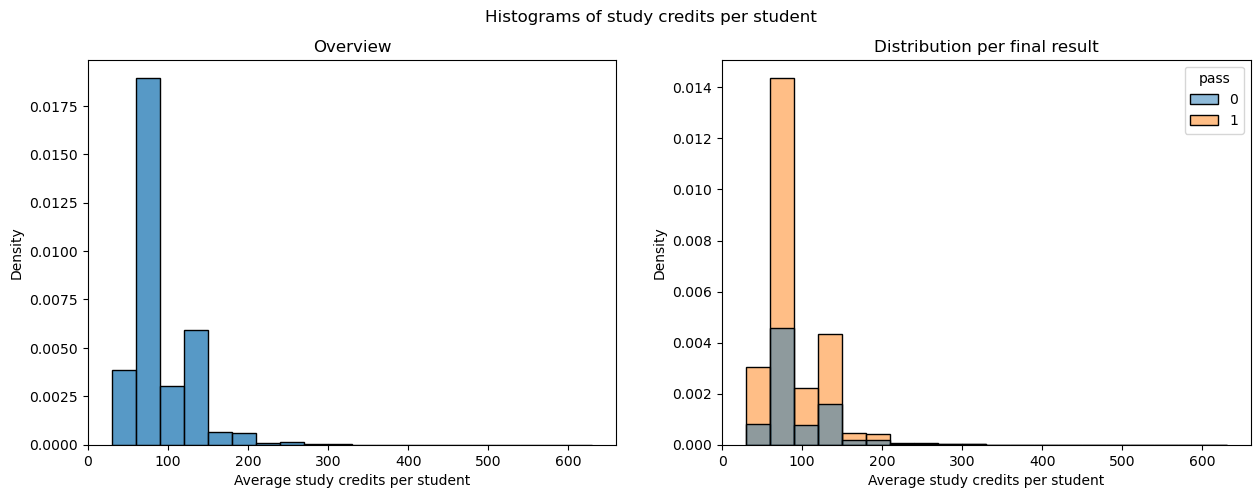

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle('Histograms of study credits per student')

sns.histplot(ax = ax[0], data = studied_df, x = 'mean', stat = 'density', bins = 20)
ax[0].set_title('Overview')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Average study credits per student')

sns.histplot(ax = ax[1], data = studied_df, x = 'mean', stat = 'density', hue = 'pass', bins = 20)
ax[1].set_xlabel('Average study credits per student')
ax[1].set_ylabel('Density')
ax[1].set_title('Distribution per final result')

plt.show()